In [1]:
# Install required packages 
!pip install mne
!pip install torch
!pip install matplotlib
!pip install scikit-learn
!pip install pandas
!pip install pyriemann


     |████████████████████████████████| 7.4 MB 4.1 MB/s 
     |████████████████████████████████| 42 kB 608 kB/s 
  Created wheel for pyriemann: filename=pyriemann-0.2.7-py2.py3-none-any.whl size=49770 sha256=4be530372338e4e35b48db07269c30295a004a435c21a902a0db05ad3a469ca9
  Stored in directory: /root/.cache/pip/wheels/5c/b7/55/27dcb08ed8fb58da8c1be108c23928ffb9125c9c1da2ddfb53
Successfully built pyriemann


In [2]:
# Identify whether a CUDA-enabled GPU is available

import torch
if torch.cuda.is_available():
    print('CUDA-enabled GPU found')
else:
    print('No GPU found')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

CUDA-enabled GPU found


In [55]:
# import general modules
import os
import copy
import warnings
warnings.filterwarnings('ignore')
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import pyriemann
from mne.externals.pymatreader import read_mat
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import itertools
from glob import glob
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## 1.  Dataset

Load the EEG recordings from shared drive or download form this link: https://zenodo.org/record/5055046#.YbNzGr3MJPb. 

This dataset has:
- 15 participants
- 3 session for each participants
- 3 levels of workload: Easy(0), Midium(1), Difficuilt(2)



## 2. Set the data path 

In [6]:
# Set the data_path 
data_path = os.getcwd()
cognitive_load_level = ['MATBeasy', 'MATBmed', 'MATBdiff']

## 3. Read Electrodes channels names and its X,Y,Z position

In [77]:
# Read Electrodes channels names and position
channels_info = pd.read_csv(data_path + '/electrode_positions/chan_locs_standard(1)', names=['ch_names','x','y','z'],sep ='\t') 
channels_info.head(15)

,ch_names,x,y,z
0,Fp1,-29.4370,83.917,-6.990
1,Fz,0.3122,58.512,66.462
2,F3,-50.2440,53.111,42.192
3,F7,-70.2630,42.474,-11.420
4,FT9,-84.0760,14.567,-50.429
5,FC5,-77.2150,18.643,24.460
6,FC1,-34.0620,26.011,79.987
7,C3,-65.3580,-11.632,64.358
8,T7,-84.1610,-16.019,-9.346
9,CP5,-79.5920,-46.551,30.949


## 4. Load RAW EEG signals and plot

In [34]:

def read_raw_signal():
    """Load a recordings 
    
    Parameters
    ----------
    raw_fname : str
        Path to the RSraw.set file containing the raw data.
    
    Returns
    -------
    raw signal: Raw object containing the EEG.  
          
    """
    ## get the raw EEG data
    data_path = os.getcwd()


    # file_name
    # PO1, S1, EEG: alldata_sbj01_sess1_RSraw.set
    no_of_subjects = 1
    session_n = 1

    for subject_n, session_n in itertools.product(range(no_of_subjects), range(no_of_sessions)):
        subject = 'P{0:02d}'.format(subject_n+1) # goes till P01 to P07 
        session = f'S{session_n+1}' 
        raw_fname = os.path.join(os.path.join(data_path, subject), session) + f'/eeg/alldata_sbj{str(subject_n+1).zfill(2)}_sess{session_n+1}_RSraw.set' # left zero padding with zfill(2)
        raw = mne.io.read_raw_eeglab(raw_fname)
        return  raw




In [35]:
# Load recordings
raws = read_raw_signal()

Using matplotlib as 2D backend.


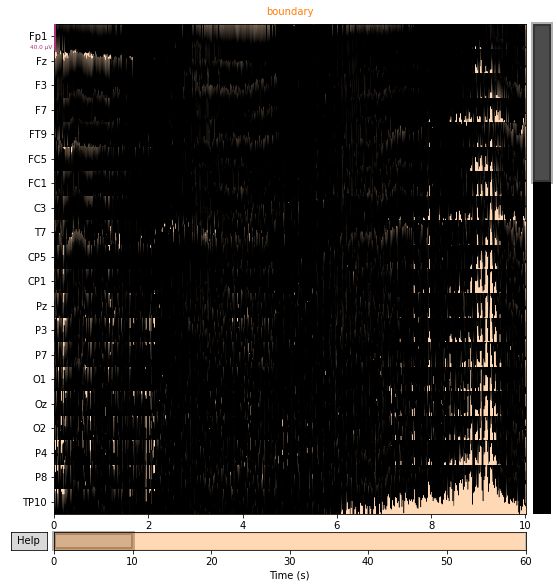

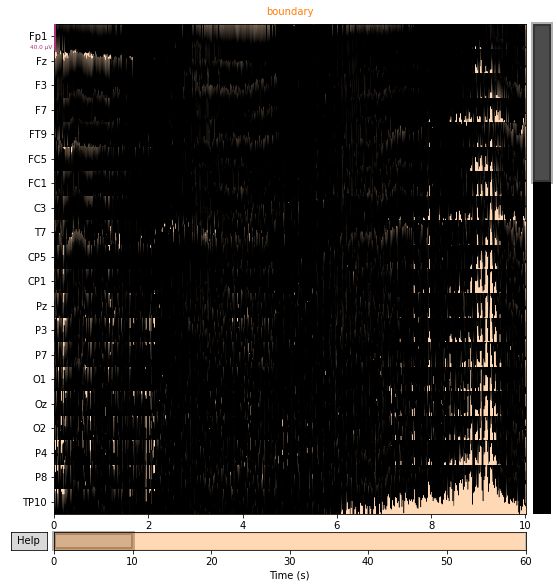

In [37]:
# Plot a recording to check 
raws.plot()

## 5. Logistic Regression Classifier 


In [61]:
logistic_reg = LogisticRegression(C=1/50.) # C = Inverse regularization parameter , check many experiemnt by tunning this paramter

## create pipeline for classfiier using covariance matrix 
## We have features in the tagnet space so use TSclassifier
classifer = make_pipeline(pyriemann.estimation.Covariances(estimator='oas'),pyriemann.classification.TSclassifier(clf=logistic_reg)) # Oracle Approximating Shrinkage (OAS)

#from imblearn.pipeline import Pipeline
#classifer = Pipeline([('lor',logistic_reg)])




## Classification with multiple participants

In [74]:

data_path = os.getcwd()
no_of_subjects = 7 
no_of_sessions = 2 #  only 2 sessions out of 3 includes all Three cognitive load level task 

for subject_n, session_n in itertools.product(range(no_of_subjects), range(no_of_sessions)): # iterate through all the dataset folders and sessions
  '''
  train_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
  label : np.ndarray
        The epochs labels, shape (n_epochs,)
  no_of_subjects : Subject number
  no_of_sessions : Session number

  '''

  train_data = []
  labels = [] # class labels: 0,1,2

  for label_id, mental_load_level in enumerate(cognitive_load_level): # for label ID and class level in dataset 
        # get the subject number
        subject = 'P{0:02d}'.format(subject_n+1) # goes till P01 to P07 
        #print(subject)
        # fetch the session
        session = f'S{session_n+1}'
        path = os.path.join(os.path.join(data_path, subject), session) + f'/eeg/alldata_sbj{str(subject_n+1).zfill(2)}_sess{session_n+1}_{mental_load_level}.set' # left zero padding with zfill(2)
        read_epochs_per_participant = mne.io.read_epochs_eeglab(path, verbose=False)

        # collect the train data for all three mental load
        data_per_mental_load = read_epochs_per_participant.get_data()
        train_data.extend(data_per_mental_load)
        labels.extend([label_id]*len(data_per_mental_load))

  train_data = np.array(train_data)
  labels = np.array(labels)





## Model Accuracy using K-Fold cross validation approach

In [108]:
# k-folds cross validation
# val_accuracy = cross_val_score(classifer, X=train_data, y=labels, cv=10) # getting 100.0%, model is over training which is not good results
# so trainignmodle on 5-folds cross validation
accuracy = cross_val_score(classifer, X=train_data, y=labels, cv=5)

# print(val_accuracy)
print(f"Best accuracy with {no_of_subjects} Participant is: {100*(max(accuracy))}%") ## 96.66666666666667





Best accuracy with 7 Participant is: 96.66666666666667%


## Tunning Inverse regularization parameter 

In [109]:
# setting different value of C 
diff_value = [10,20,30,40,50]
for val in range(len(diff_value)):
    logistic_reg = LogisticRegression(C=1/diff_value[val]) 
    classifer = make_pipeline(pyriemann.estimation.Covariances(estimator='oas'),pyriemann.classification.TSclassifier(clf=logistic_reg)) 
    data_path = os.getcwd()

    no_of_subjects = 7 
    no_of_sessions = 2 

    for subject_n, session_n in itertools.product(range(no_of_subjects), range(no_of_sessions)): 
      '''
      train_data : np.ndarray
            The epochs data, shape (n_epochs, n_channels, n_times).
      label : np.ndarray
            The epochs labels, shape (n_epochs,)
      no_of_subjects : Subject number
      no_of_sessions : Session number

      '''

      train_data = []
      labels = [] 

      for label_id, mental_load_level in enumerate(cognitive_load_level): 
            subject = 'P{0:02d}'.format(subject_n+1) 
            #print(subject)
            session = f'S{session_n+1}'
            path = os.path.join(os.path.join(data_path, subject), session) + f'/eeg/alldata_sbj{str(subject_n+1).zfill(2)}_sess{session_n+1}_{mental_load_level}.set' # left zero padding with zfill(2)
            read_epochs_per_participant = mne.io.read_epochs_eeglab(path, verbose=False)

            data_per_mental_load = read_epochs_per_participant.get_data()
            train_data.extend(data_per_mental_load)
            labels.extend([label_id]*len(data_per_mental_load))

      train_data = np.array(train_data)
      labels = np.array(labels)



    val_accuracy = cross_val_score(classifer, X=train_data, y=labels, cv=5)
    print(f"Accuracy with C = {diff_value[val]} is: {100*(max(val_accuracy))}%") 
    

Accuracy with C = 10 is: 98.87640449438202%
Accuracy with C = 20 is: 98.87640449438202%
Accuracy with C = 30 is: 98.88888888888889%
Accuracy with C = 40 is: 97.77777777777777%
Accuracy with C = 50 is: 96.66666666666667%


### TODO:
- check the dataset on multiple classifier and find the best score
- train the model on individual participants
- create a file to save all the results